## Random Forest

In [1]:
import pandas as pd
data = pd.read_excel("open_crosion.xlsx")
data.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Label,Experiment,X-Coordinate,Y-Coordinate,Specimen
0,-0.793526,-0.564884,-0.918486,-2.643592,-0.405808,1.555672,-1.282668,1,5,53.5,40.0,1
1,-1.131818,-0.564884,-0.934511,-2.750356,-0.279310,1.275645,-2.688708,1,5,54.0,30.5,1
2,-1.120734,-0.564884,-0.951459,-2.863264,-0.298150,1.378301,-2.487164,1,5,54.0,31.0,1
3,-1.106464,-0.564884,-0.968407,-2.976173,-0.316991,1.480956,-2.505143,1,5,54.0,31.5,1
4,-1.090652,-0.564884,-0.985354,-3.089081,-0.335831,1.583612,-2.578003,1,5,54.0,32.0,1


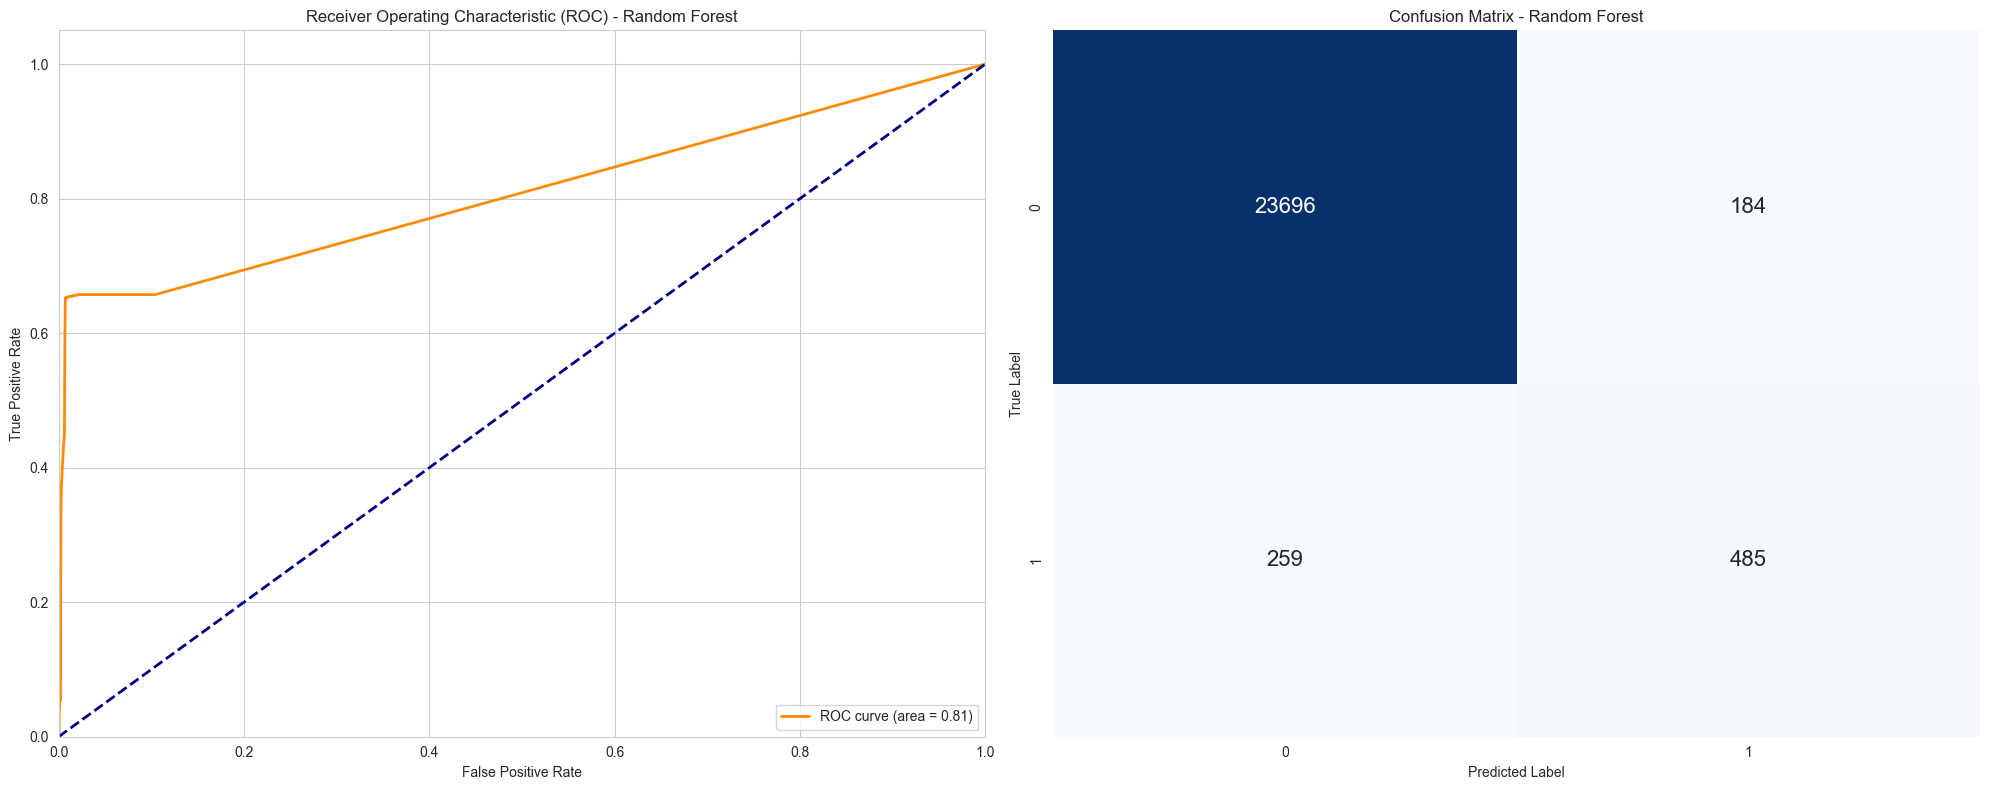

(0.9820094217024041,
 array([[23696,   184],
        [  259,   485]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99     23880\n           1       0.72      0.65      0.69       744\n\n    accuracy                           0.98     24624\n   macro avg       0.86      0.82      0.84     24624\nweighted avg       0.98      0.98      0.98     24624\n')

In [2]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import itertools

data = pd.read_excel("open_crosion.xlsx")
# Splitting the data into training set from specimen 1 and testing set from specimen 2
specimen_1_data = data[data['Specimen'] == 1]
specimen_2_data = data[data['Specimen'] == 2]

input_features = ['Feature 3', 'Feature 4', 'Feature 5', 'Feature 6']
target_variable = 'Label'

X_train = specimen_1_data[input_features]
y_train = specimen_1_data[target_variable]

X_test = specimen_2_data[input_features]
y_test = specimen_2_data[target_variable]


# Creating and fitting the Random Forest model on the unbalanced dataset
rf_model_unbalanced = RandomForestClassifier()
rf_model_unbalanced.fit(X_train, y_train)

# Predicting on the test set
rf_y_pred_unbalanced = rf_model_unbalanced.predict(X_test)

# Evaluating the Random Forest model
rf_accuracy_unbalanced = accuracy_score(y_test, rf_y_pred_unbalanced)
rf_conf_matrix_unbalanced = confusion_matrix(y_test, rf_y_pred_unbalanced)
rf_class_report_unbalanced = classification_report(y_test, rf_y_pred_unbalanced)

# Calculate the ROC curve and AUC for Random Forest
rf_fpr_unbalanced, rf_tpr_unbalanced, _ = roc_curve(y_test, rf_model_unbalanced.predict_proba(X_test)[:, 1])
rf_roc_auc_unbalanced = auc(rf_fpr_unbalanced, rf_tpr_unbalanced)

# Adjusting the figure size and layout spacing
plt.figure(figsize=(20, 8))  # Increase the figure size for better readability

sns.set_style("whitegrid")

# Subplot 1: ROC Curve for Random Forest
plt.subplot(1, 2, 1)
plt.plot(rf_fpr_unbalanced, rf_tpr_unbalanced, color='darkorange', lw=2, label=f'ROC curve (area = {rf_roc_auc_unbalanced:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")

# Subplot 2: Confusion Matrix for Random Forest
plt.subplot(1, 2, 2)
sns.heatmap(rf_conf_matrix_unbalanced, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')

# Adjusting layout spacing for better visibility and to prevent overlap
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

plt.tight_layout()
plt.savefig('RandomForest_ROC_and_ConfusionMatrix.png', dpi=300)  # Save the figure with high resolution
plt.show()

rf_accuracy_unbalanced, rf_conf_matrix_unbalanced, rf_class_report_unbalanced


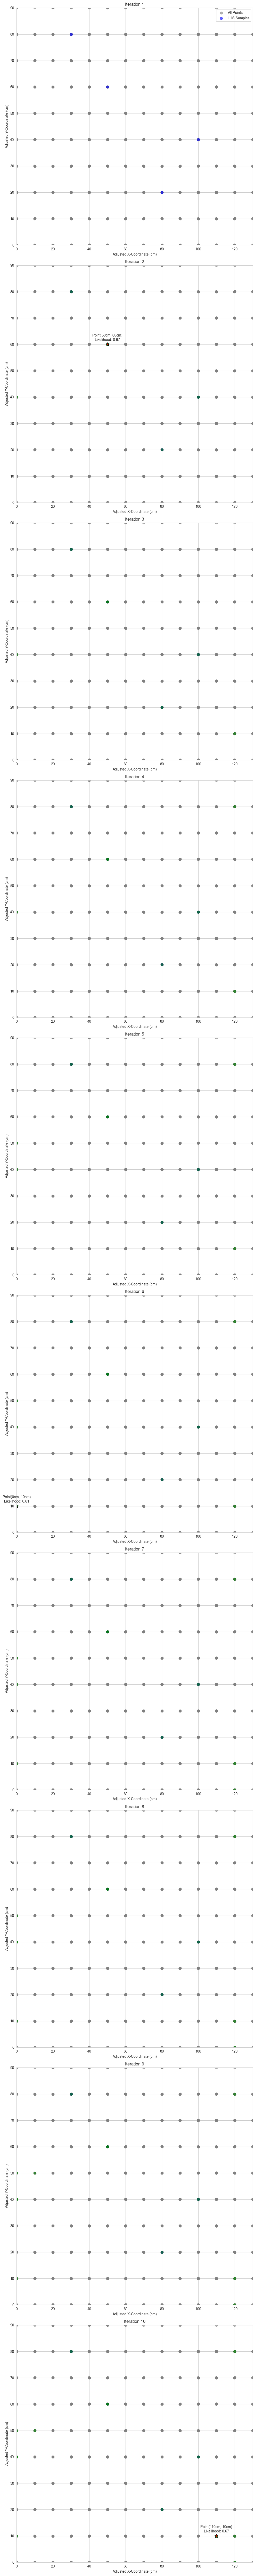

Total iterations: 10
Total unique samples evaluated (including initial samples): 13
Total corrosion points detected (including initial samples): 3
Corrosion detected in iterations: [1, 5, 9]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Your data loading and coordinate adjustment code
data = pd.read_excel("open_crosion.xlsx")
features = ['Feature 3', 'Feature 4', 'Feature 5', 'Feature 6']
# Determine the boundaries of the current X and Y coordinates
x_min, x_max = data['X-Coordinate'].min(), data['X-Coordinate'].max()
y_min, y_max = data['Y-Coordinate'].min(), data['Y-Coordinate'].max()

# Adjust the coordinates to fit the 13x10 grid for the 130x90 cm measurement field
data['X-Coordinate_Adjusted_10'] = (data['X-Coordinate'] / 10).round().astype(int)
data['Y-Coordinate_Adjusted_10'] = (data['Y-Coordinate'] / 10).round().astype(int)

# Setup GPR Model
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1)
gpr = GaussianProcessRegressor(kernel=kernel)

def latin_hypercube_sampling(data, n_samples):
    """Generate Latin Hypercube Samples from data."""
    # Divide the range of data into n_samples intervals
    intervals = np.linspace(0, 1, n_samples + 1)
    # Randomly select a point within each interval
    random_samples = [np.random.uniform(low=intervals[i], high=intervals[i+1]) for i in range(n_samples)]
    # Shuffle the array to ensure randomness
    np.random.shuffle(random_samples)
    # Scale the random values to the actual range of the data
    scaled_samples = [sample * (data.max() - data.min()) + data.min() for sample in random_samples]
    return scaled_samples



def plot_adaptive_sampling(lhs_samples, cumulative_samples, new_sample, iteration, criteria_met, likelihood, ax):
    # Plot all points as gray dots
    ax.scatter(data_17['X-Coordinate_Adjusted_10'] * 10, data_17['Y-Coordinate_Adjusted_10'] * 10, color='gray', s=50, alpha=0.6, label='All Points' if iteration == 0 else "")

    # Plot LHS samples as blue dots
    ax.scatter(lhs_samples['X-Coordinate_Adjusted_10'] * 10, lhs_samples['Y-Coordinate_Adjusted_10'] * 10, color='blue', s=50, alpha=0.6, label='LHS Samples' if iteration == 0 else "")

    # From the second iteration onwards, include cumulative samples as green dots
    if iteration > 0:
        ax.scatter(cumulative_samples['X-Coordinate_Adjusted_10'] * 10, cumulative_samples['Y-Coordinate_Adjusted_10'] * 10, color='green', s=50, alpha=0.6, label='Cumulative Samples' if iteration == 0 else "")

    # Annotating the new sample point if criteria are met (as a red star)
    if criteria_met:
        x_coord = new_sample['X-Coordinate_Adjusted_10'].values[0] * 10
        y_coord = new_sample['Y-Coordinate_Adjusted_10'].values[0] * 10
        ax.scatter(x_coord, y_coord, color='red', s=100, edgecolor='k', marker='*', label='Corrosion Point' if iteration == 0 else "")
        ax.annotate(f'Point({x_coord}cm, {y_coord}cm)\nLikelihood: {likelihood:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')

    # Maintain the original axis labels, title, and grid settings
    ax.set_xlabel('Adjusted X-Coordinate (cm)')
    ax.set_ylabel('Adjusted Y-Coordinate (cm)')
    ax.set_title(f'Iteration {iteration + 1}')
    ax.grid(True)
    ax.set_xlim([0, 130])
    ax.set_ylim([0, 90])
    if iteration == 0:  # Only add the legend in the first plot to avoid repetition
        ax.legend()


def filter_experiment_data(data, experiment_number, include_corrosion=False):
    """
    Filters the data for a specific experiment and optionally excludes corrosion points.

    Parameters:
    - data: The full dataset.
    - experiment_number: The experiment number to filter by (17 or 18).
    - include_corrosion: Whether to include corrosion points. Defaults to False.

    Returns:
    - Filtered DataFrame.
    """
    # Filter data by experiment number
    experiment_data = data[data['Experiment'] == experiment_number]

    if not include_corrosion:
        # Assuming 'Corrosion_Flag' indicates corrosion presence (1 for corrosion, 0 for non-corrosion)
        experiment_data = experiment_data[experiment_data['Label'] == 0]

    # Reset index for clean processing downstream
    return experiment_data.reset_index(drop=True)

# Usage example for Experiment 17, excluding corrosion points
data_17 = filter_experiment_data(data, 17, include_corrosion=False)

# Usage example for Experiment 18, excluding corrosion points
#data_17 = filter_experiment_data(data, 18, include_corrosion=False)



# Filter data for Experiment 18
# data_17 = data[data['Experiment'] == 17]
# # Resetting the index for data_17
# data_17 = data_17.reset_index(drop=True)



# Set the number of iterations and initial sample size
num_iterations = 10  # Specify the desired number of iterations
initial_sample_size = 4  # Specify the initial sample size

# Initial Latin Hypercube Sampling to generate initial samples
lhs_x_samples = latin_hypercube_sampling(data_17['X-Coordinate_Adjusted_10'], initial_sample_size)
lhs_y_samples = latin_hypercube_sampling(data_17['Y-Coordinate_Adjusted_10'], initial_sample_size)

initial_samples = []
for x, y in zip(lhs_x_samples, lhs_y_samples):
    distances = np.sqrt((data_17['X-Coordinate_Adjusted_10'] - x) ** 2 + (data_17['Y-Coordinate_Adjusted_10'] - y) ** 2)
    nearest_point = data_17.iloc[distances.idxmin()]
    initial_samples.append(nearest_point)

# Convert initial samples to DataFrame
lhs_samples = pd.DataFrame(initial_samples)
cumulative_samples = lhs_samples.copy()  # To include new samples in each iteration
unselected_data = data_17.drop(lhs_samples.index)

# Initialize variables for summary
total_iterations = 0
unique_samples_evaluated = set()  # To track unique samples evaluated
corrosion_points_detected = 0
corrosion_detected_iterations = []

# Initialize figure for adaptive sampling visualization
plt.figure(figsize=(10, 100))  # Adjust the figure size as needed

# Main loop for adaptive sampling
for iteration in range(num_iterations):
    total_iterations += 1  # Increment total iterations counter
    X_selected = cumulative_samples[features]
    y_pred_proba = rf_model_unbalanced.predict_proba(X_selected)[:, 1]

    # Fit GPR Model based on RF model output
    gpr.fit(X_selected, y_pred_proba)

    # Predict for the rest of the data
    X_unselected = unselected_data[features]
    gpr_output, gpr_uncertainty = gpr.predict(X_unselected, return_std=True)

    # Select a new sample based on highest GPR uncertainty
    idx_new_sample = np.argmax(gpr_uncertainty)
    new_sample = unselected_data.iloc[[idx_new_sample]]

    # Predicting label and likelihood for the new sample
    predicted_label = rf_model_unbalanced.predict(new_sample[features])
    predicted_proba = rf_model_unbalanced.predict_proba(new_sample[features])[:, 1][0]

    # Update unique samples evaluated
    unique_samples_evaluated.update(cumulative_samples.index.tolist())

    # Check if the new point meets the criteria for corrosion detection
    if predicted_label[0] == 1 and predicted_proba > 0.5:
        corrosion_points_detected += 1
        corrosion_detected_iterations.append(iteration)

    # Update the sets of selected and unselected samples
    cumulative_samples = pd.concat([cumulative_samples, new_sample])

    # Drop the new sample from unselected_data using a boolean mask
    mask = unselected_data.index.isin(new_sample.index)
    unselected_data = unselected_data[~mask].reset_index(drop=True)

    # Select the subplot for the current iteration
    ax = plt.subplot(num_iterations, 1, iteration + 1)  # Create a subplot for each iteration in a single column
    criteria_met = predicted_label[0] == 1 and predicted_proba > 0.5
    plot_adaptive_sampling(lhs_samples, cumulative_samples, new_sample, iteration, criteria_met, predicted_proba, ax)


plt.tight_layout()
plt.show()

# Summary output
print(f"Total iterations: {total_iterations}")
print(f"Total unique samples evaluated (including initial samples): {len(unique_samples_evaluated)}")
print(f"Total corrosion points detected (including initial samples): {corrosion_points_detected}")
print(f"Corrosion detected in iterations: {corrosion_detected_iterations}")



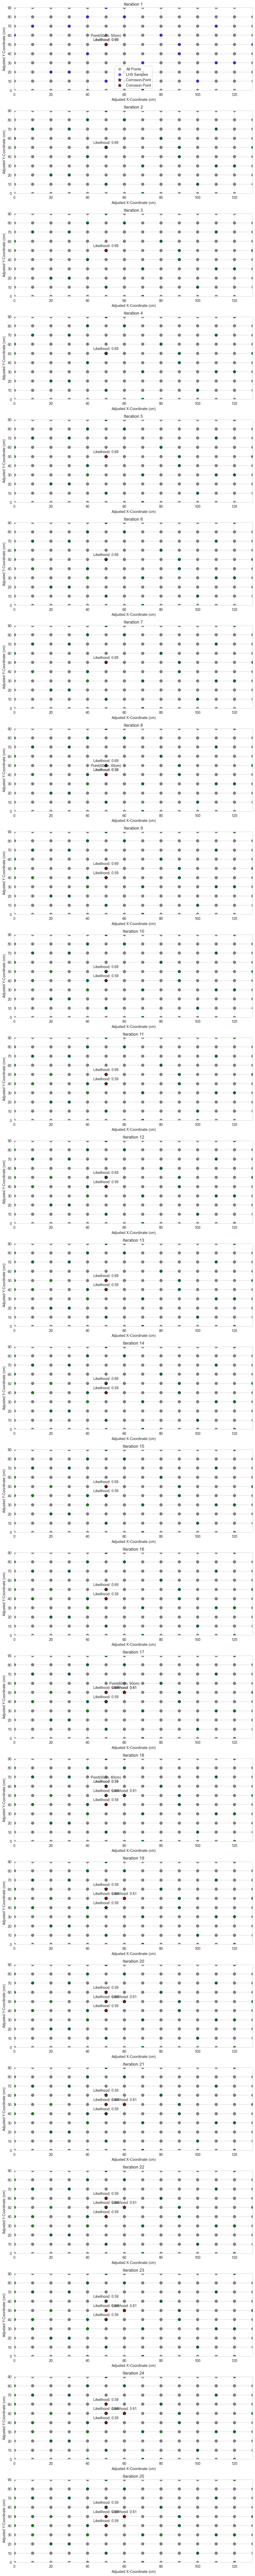

Total iterations: 25
Total unique samples evaluated (including initial samples): 42
Total corrosion points detected (including initial samples): 4
Corrosion detected in iterations: [0, 7, 16, 17]


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Your data loading and coordinate adjustment code
data = pd.read_excel("open_crosion.xlsx")
features = ['Feature 3', 'Feature 4', 'Feature 5', 'Feature 6']
# Determine the boundaries of the current X and Y coordinates
x_min, x_max = data['X-Coordinate'].min(), data['X-Coordinate'].max()
y_min, y_max = data['Y-Coordinate'].min(), data['Y-Coordinate'].max()

# Adjust the coordinates to fit the 13x10 grid for the 130x90 cm measurement field
data['X-Coordinate_Adjusted_10'] = (data['X-Coordinate'] / 10).round().astype(int)
data['Y-Coordinate_Adjusted_10'] = (data['Y-Coordinate'] / 10).round().astype(int)

# Setup GPR Model
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1)
gpr = GaussianProcessRegressor(kernel=kernel)

def latin_hypercube_sampling(data, n_samples):
    """Generate Latin Hypercube Samples from data."""
    # Divide the range of data into n_samples intervals
    intervals = np.linspace(0, 1, n_samples + 1)
    # Randomly select a point within each interval
    random_samples = [np.random.uniform(low=intervals[i], high=intervals[i+1]) for i in range(n_samples)]
    # Shuffle the array to ensure randomness
    np.random.shuffle(random_samples)
    # Scale the random values to the actual range of the data
    scaled_samples = [sample * (data.max() - data.min()) + data.min() for sample in random_samples]
    return scaled_samples



def plot_adaptive_sampling(lhs_samples, cumulative_samples, new_sample, criteria_met, iteration, corrosion_points_list, likelihood, ax):
    # Plot all points as gray dots
    ax.scatter(data_17['X-Coordinate_Adjusted_10'] * 10, data_17['Y-Coordinate_Adjusted_10'] * 10, color='gray', s=50, alpha=0.6, label='All Points' if iteration == 0 else "")

    # Plot LHS samples as blue dots
    ax.scatter(lhs_samples['X-Coordinate_Adjusted_10'] * 10, lhs_samples['Y-Coordinate_Adjusted_10'] * 10, color='blue', s=50, alpha=0.6, label='LHS Samples' if iteration == 0 else "")

    # From the second iteration onwards, include cumulative samples as green dots
    if iteration > 0:
        ax.scatter(cumulative_samples['X-Coordinate_Adjusted_10'] * 10, cumulative_samples['Y-Coordinate_Adjusted_10'] * 10, color='green', s=50, alpha=0.6, label='Cumulative Samples' if iteration == 0 else "")

    # Annotating the new sample point if criteria are met (as a red star)
    if criteria_met:
        x_coord = new_sample['X-Coordinate_Adjusted_10'].values[0] * 10
        y_coord = new_sample['Y-Coordinate_Adjusted_10'].values[0] * 10
        ax.scatter(x_coord, y_coord, color='red', s=100, edgecolor='k', marker='*', label='Corrosion Point' if iteration == 0 else "")
        ax.annotate(f'Point({x_coord}cm, {y_coord}cm)\nLikelihood: {likelihood:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')
     # Plot each stored corrosion point
    for x_coord, y_coord, likelihood in corrosion_points_list:
        ax.scatter(x_coord, y_coord, color='red', s=100, edgecolor='k', marker='*', label='Corrosion Point' if iteration == 0 else "")
        ax.annotate(f'Likelihood: {likelihood:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')
    # Maintain the original axis labels, title, and grid settings
    ax.set_xlabel('Adjusted X-Coordinate (cm)')
    ax.set_ylabel('Adjusted Y-Coordinate (cm)')
    ax.set_title(f'Iteration {iteration + 1}')
    ax.grid(True)
    ax.set_xlim([0, 130])
    ax.set_ylim([0, 90])
    if iteration == 0:  # Only add the legend in the first plot to avoid repetition
        ax.legend()


# Filter data for Experiment 17
# data_17 = data[data['Experiment'] == 17]
# # Resetting the index for data_17
# data_17 = data_17.reset_index(drop=True)

# Filter data for Experiment 18
data_18 = data[data['Experiment'] == 18]
# Resetting the index for data_17
data_17 = data_18.reset_index(drop=True)

# Set the number of iterations and initial sample size
num_iterations = 25  # Specify the desired number of iterations
initial_sample_size = 20  # Specify the initial sample size

# Initial Latin Hypercube Sampling to generate initial samples
lhs_x_samples = latin_hypercube_sampling(data_17['X-Coordinate_Adjusted_10'], initial_sample_size)
lhs_y_samples = latin_hypercube_sampling(data_17['Y-Coordinate_Adjusted_10'], initial_sample_size)

initial_samples = []
for x, y in zip(lhs_x_samples, lhs_y_samples):
    distances = np.sqrt((data_17['X-Coordinate_Adjusted_10'] - x) ** 2 + (data_17['Y-Coordinate_Adjusted_10'] - y) ** 2)
    nearest_point = data_17.iloc[distances.idxmin()]
    initial_samples.append(nearest_point)

# Convert initial samples to DataFrame
lhs_samples = pd.DataFrame(initial_samples)
cumulative_samples = lhs_samples.copy()  # To include new samples in each iteration
unselected_data = data_17.drop(lhs_samples.index)

# Initialize variables for summary
total_iterations = 0
unique_samples_evaluated = set()  # To track unique samples evaluated
corrosion_points_detected = 0
corrosion_detected_iterations = []

# Initialize figure for adaptive sampling visualization
plt.figure(figsize=(10, 100))  # Adjust the figure size as needed
corrosion_points_list = []

# Main loop for adaptive sampling
for iteration in range(num_iterations):
    total_iterations += 1  # Increment total iterations counter
    X_selected = cumulative_samples[features]
    y_pred_proba = rf_model_unbalanced.predict_proba(X_selected)[:, 1]

    # Fit GPR Model based on RF model output
    gpr.fit(X_selected, y_pred_proba)

    # Predict for the rest of the data
    X_unselected = unselected_data[features]
    gpr_output, gpr_uncertainty = gpr.predict(X_unselected, return_std=True)

    # Select a new sample based on highest GPR uncertainty
    idx_new_sample = np.argmax(gpr_uncertainty)
    new_sample = unselected_data.iloc[[idx_new_sample]]

    # Predicting label and likelihood for the new sample
    predicted_label = rf_model_unbalanced.predict(new_sample[features])
    predicted_proba = rf_model_unbalanced.predict_proba(new_sample[features])[:, 1][0]

    # Update unique samples evaluated
    unique_samples_evaluated.update(cumulative_samples.index.tolist())

        # Check if the new point meets the criteria for corrosion detection
    if predicted_label[0] == 1 and predicted_proba > 0.5:
        corrosion_points_detected += 1
        corrosion_detected_iterations.append(iteration)
        # Store the new corrosion point's coordinates and likelihood
        corrosion_points_list.append((new_sample['X-Coordinate_Adjusted_10'].values[0] * 10, new_sample['Y-Coordinate_Adjusted_10'].values[0] * 10, predicted_proba))


    # Update the sets of selected and unselected samples
    cumulative_samples = pd.concat([cumulative_samples, new_sample])

    # Drop the new sample from unselected_data using a boolean mask
    mask = unselected_data.index.isin(new_sample.index)
    unselected_data = unselected_data[~mask].reset_index(drop=True)

    criteria_met = predicted_label[0] == 1 and predicted_proba > 0.5
   # Select the subplot for the current iteration
    ax = plt.subplot(num_iterations, 1, iteration + 1)
    # Update plot for each iteration, passing the list of all corrosion points detected so far
    plot_adaptive_sampling(lhs_samples, cumulative_samples, new_sample,criteria_met, iteration, corrosion_points_list,predicted_proba, ax)


plt.tight_layout()
plt.show()

# Summary output
print(f"Total iterations: {total_iterations}")
print(f"Total unique samples evaluated (including initial samples): {len(unique_samples_evaluated)}")
print(f"Total corrosion points detected (including initial samples): {corrosion_points_detected}")
print(f"Corrosion detected in iterations: {corrosion_detected_iterations}")

